# Пайплайн для выделения лучших кропов по текстовому запросу Yolo -> Clip -> Annoy

Все расчеты ниже получены по **train** выборке датасета LVIS

* Применяем модель YoloV5L к датасету, получаем кропы для картинок
* Применяем модель clip к каждому кропу, получаем эмбеддинги кропов
* Применяем модель clip к описанию категорий датасета LVIS, получаем эмбеддинги категорий
* Строим индекс annoy по эмбеддингам кропов для поиска ближайших соседей из кропов к каждой категории датасета
* Проводим анализ метрик

В дальнейшем полученный индекс annoy будет использоваться в ДЕМО для поиска подходящих кропов (из valid части датасета LVIS) для текстового запроса пользователя

In [1]:
import sys

sys.path.append("../yolov5")

In [2]:
from assh_utils import Batch, get_iou, load_json, nms

In [3]:
from yolo_utils import CustomWrapper, DetectMultiBackend

In [4]:
import os

root = "/home/jupyter/mnt/s3/asciishell-fsod/LVIS/train2017"
js = load_json("/home/jupyter/mnt/s3/asciishell-fsod/LVIS/lvis_v1_train.json.zip")
images = ["{}/{:012d}.jpg".format(root, x["id"]) for x in js["images"]]
assert all([os.path.exists(x) for x in images[:100]])

In [12]:
import itertools
import math
import os
import pickle

import clip
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
from annoy import AnnoyIndex
from sklearn.cluster import KMeans
from sklearn.metrics import average_precision_score
from tqdm.cli import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


## Применяем модель YoloV5L с KMeans + NMS
Сохраняем датафрейм с картинками и соответствующими кропами.

In [6]:
model = CustomWrapper(DetectMultiBackend("./yolov5l.pt", device="cuda"))

Fusing layers... 
Model Summary: 367 layers, 46533693 parameters, 0 gradients
Adding AutoShape... 


In [7]:
results = []
for names in tqdm(Batch(images, 32)):
    pack = names.copy()
    res = model(pack)
    for im, df in zip(names, res.pandas().xyxy):
        if not len(df):
            continue
        kmeans = KMeans(n_clusters=max(min(30, len(df) // 2), 1), random_state=0, verbose=0).fit(
            df[["xmin", "ymin", "xmax", "ymax"]]
        )
        df["labels"] = kmeans.labels_
        df["image"] = im
        for label in df["labels"].unique():
            match = df[df["labels"] == label]
            keep = nms(match[["xmin", "ymin", "xmax", "ymax"]].values, match["confidence"].values, 0.45, max_dets=10)
            results.extend(match.iloc[keep].to_dict("records"))
results = pd.DataFrame(results)
results.to_pickle(f"/home/jupyter/mnt/s3/asciishell-fsod/RunYoloV2/train.pkl.zip")

100%|██████████| 3131/3131 [8:54:22<00:00, 10.24s/it]


In [8]:
results.head()

,xmin,ymin,xmax,ymax,confidence,class,name,labels,image
0,471.249146,172.365234,492.173279,201.671326,0.014954,0,person,18,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...
1,471.846619,172.809540,514.531738,206.781403,0.039575,0,person,15,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...
2,499.450653,175.113068,518.701111,207.357941,0.017261,0,person,14,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...
3,470.844879,172.564880,490.131989,222.423096,0.043413,0,person,10,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...
4,472.058746,172.983063,509.350311,219.210541,0.176536,0,person,0,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...


Округляем границы bbox. Удаяем слишком маленькие кропы и дубликаты. Сохраняем отсортированный и сокращенный датафрейм с картинками и кропами.

In [9]:
dfs = pd.read_pickle("/home/jupyter/mnt/s3/asciishell-fsod/RunYoloV2/train.pkl.zip")
dfs[["xmin", "ymin", "xmax", "ymax"]] = dfs[["xmin", "ymin", "xmax", "ymax"]].round().astype(np.int32).values
dfs = dfs[((dfs["xmin"] - dfs["xmax"]).abs() > 5) & ((dfs["ymin"] - dfs["ymax"]).abs() > 5)]
dfs = (
    dfs.sort_values(["image"])
    .drop_duplicates(["xmin", "ymin", "xmax", "ymax", "image"], keep="first")
    .sort_values(["image", "confidence", "xmin", "ymin", "xmax", "ymax"])
    .reset_index(drop=True)
)
dfs.to_pickle("/home/jupyter/mnt/s3/asciishell-fsod/RunYoloV2/train.sorted.pkl.zip")
dfs

,xmin,ymin,xmax,ymax,confidence,class,name,labels,image
0,511,151,639,314,0.010366,58,potted plant,5,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...
1,9,202,43,231,0.010399,32,sports ball,4,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...
2,210,32,469,349,0.010737,58,potted plant,9,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...
3,508,210,636,315,0.010960,58,potted plant,13,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...
4,516,210,639,312,0.011726,58,potted plant,1,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...
...,...,...,...,...,...,...,...,...,...
4275357,249,164,452,343,0.868056,17,horse,16,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...
4275358,331,114,384,157,0.881223,17,horse,25,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...
4275359,331,114,384,156,0.918944,17,horse,21,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...
4275360,247,164,451,343,0.922515,17,horse,12,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...


## Применяем модель clip к каждому кропу

Сохраняем полученные эмбеддинги для каждого кропа и датафрейм с картинками и кропами в соответствующем порядке.

In [10]:
clip_model, clip_preprocess = clip.load("/home/jupyter/mnt/s3/asciishell-fsod/models/ViT-B-32.pt", device)

In [11]:
embeddings = []
images = []
for index, row in tqdm(dfs.groupby("image")):
    img = PIL.Image.open(index)
    for _, row2 in row.iterrows():
        img_crop = img.crop(box=row2[["xmin", "ymin", "xmax", "ymax"]].values)
        image_input = clip_preprocess(img_crop).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = clip_model.encode_image(image_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        embeddings.append(image_features[0].cpu().numpy())
        images.append(row2.to_dict())
embeddings = np.stack(embeddings)
images = pd.DataFrame(images)
np.save("/home/jupyter/mnt/s3/asciishell-fsod/RunYoloV2/train_emb.npy", embeddings)
images.to_pickle("/home/jupyter/mnt/s3/asciishell-fsod/RunYoloV2/train.done.pkl.zip")

100%|██████████| 100059/100059 [19:27:00<00:00,  1.43it/s]


In [6]:
embeddings = np.load("/home/jupyter/mnt/s3/asciishell-fsod/RunYoloV2/train_emb.npy")
images = pd.read_pickle("/home/jupyter/mnt/s3/asciishell-fsod/RunYoloV2/train.done.pkl.zip")

In [7]:
embeddings.shape

(4275362, 512)

## Получим эмбеддинг для определения каждой категории датасета LVIS
Сохраним категорию и соответствующий ей эмбеддинг.

In [5]:
def get_vector_text(x):
    text_inputs = torch.cat([clip.tokenize(x)]).to(device)
    with torch.no_grad():
        text_features = clip_model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features[0].cpu().numpy()


def get_vector_image(x):
    img = PIL.Image.open(x)
    img.thumbnail((640, 640), PIL.Image.ANTIALIAS)
    img.show()
    image_input = clip_preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(image_input)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    return image_features[0].cpu().numpy()

In [8]:
categories_emb = []
categories = []
for category in tqdm(js["categories"]):
    categories_emb.append(get_vector_text(category["def"]))
    categories.append(category)
categories_emb = np.stack(categories_emb)
categories = pd.DataFrame(categories)
np.save("/home/jupyter/mnt/s3/asciishell-fsod/RunYolo/categories_emb.npy", categories_emb)
categories.to_pickle("/home/jupyter/mnt/s3/asciishell-fsod/RunYolo/categories.pkl.zip")

In [8]:
categories_emb = np.load("/home/jupyter/mnt/s3/asciishell-fsod/RunYolo/categories_emb.npy")
categories = pd.read_pickle("/home/jupyter/mnt/s3/asciishell-fsod/RunYolo/categories.pkl.zip")

## Для эмбеддинга каждой категории найдем n ближайших соседей из эмбеддингов кропов

In [9]:
t = AnnoyIndex(embeddings.shape[1], "angular")
for i, v in enumerate(embeddings):
    t.add_item(i, v)
t.build(30)
t.save("/home/jupyter/mnt/s3/asciishell-fsod/RunYoloV2/train_100.ann")

True

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: t
  warnings.warn(message)


In [13]:
t = AnnoyIndex(512, "angular")
t.load("/home/jupyter/mnt/s3/asciishell-fsod/RunYoloV2/train_100.ann")

True

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: t
  warnings.warn(message)


## Проводим анализ метрик
Определим, относятся ли в действительности выделенные кропы к заданной категории (с помощью iou) и вычислим метрики качества.

In [91]:
metrics = []
annotation = pd.DataFrame(js['annotations'])
for index, category in tqdm(categories.iterrows(), total=categories.shape[0]):
    best = t.get_nns_by_vector(categories_emb[index], 30, search_k=-1, include_distances=True) # сколько есть максимально объектов каждой категории:
    x_conf = images.loc[best[0], 'confidence']
    tp = []
    x_iou = []
    for x in best[0]: # имеет ли смысл убрать кропы с одной картинки с большим iou?
        img = images.loc[x]
        for ann in annotation[annotation['image_id'] == int(img['image'][-16:-4])].iterrows():
            ann = ann[1]
            iou = get_iou({'x1': img['xmin'], 'x2': img['xmax'], 'y1': img['ymin'], 'y2': img['ymax']}, 
                    {'x1': ann['bbox'][0], 'x2': ann['bbox'][0] + ann['bbox'][2], 'y1': ann['bbox'][1], 'y2': ann['bbox'][1] + ann['bbox'][3]})
            if iou > 0.5 and ann['category_id'] == category['id']: # стоит ли рассматривать разные iou?
                x_iou.append(iou)
                tp.append(1)
                break
        else:
            x_iou.append(None)
            tp.append(0)
            
    for n_neighb in [1, 5, 10, 20, 30]: 
        metrics.append({
                        'category_id': category['id'], 
                        'category_name': category['name'],
                        'n_neighb': n_neighb,
                        'average_precision_conf': average_precision_score(tp[:n_neighb], x_conf[:n_neighb]),
                        'average_precision_dist': average_precision_score(tp[:n_neighb], 1 / np.array(best[1][:n_neighb])),
                        'average_precision_multi': average_precision_score(tp[:n_neighb], np.array(x_conf[:n_neighb]) / np.array(best[1][:n_neighb])),
                        'tp': np.sum(tp[:n_neighb]),
                        'dist_mean': np.mean(best[1][:n_neighb]), 
                        'conf_mean': np.mean(x_conf[:n_neighb]), 
                        'iou_mean': np.mean([x for x in x_iou[:n_neighb] if x is not None], dtype=np.float64), 
                       })
    
metrics = pd.DataFrame(metrics)
metrics.to_pickle('/home/jupyter/mnt/s3/asciishell-fsod/RunYoloV2/train_metrics_100.pkl.zip')

100%|██████████| 1203/1203 [01:29<00:00, 13.45it/s]
/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: t
  warnings.warn(message)


In [98]:
metrics["accuracy"] = metrics["tp"] / metrics["n_neighb"]

In [99]:
metrics.head()

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,average_precision_multi,tp,dist_mean,conf_mean,iou_mean,accuracy
0,1,aerosol_can,1,NaN,NaN,NaN,0,1.150666,0.884546,NaN,0.0
1,1,aerosol_can,5,NaN,NaN,NaN,0,1.156089,0.487536,NaN,0.0
2,1,aerosol_can,10,NaN,NaN,NaN,0,1.158153,0.349877,NaN,0.0
3,1,aerosol_can,20,NaN,NaN,NaN,0,1.161081,0.400785,NaN,0.0
4,1,aerosol_can,30,NaN,NaN,NaN,0,1.163212,0.325543,NaN,0.0


In [100]:
# в топе по accuracy простые и понятные категории (животные, популярные предметы)
metrics_ = metrics[metrics["n_neighb"] == 10]
metrics_.sort_values("accuracy", ascending=False).head(10)

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,average_precision_multi,tp,dist_mean,conf_mean,iou_mean,accuracy
2842,569,horse,10,1.000000,1.000000,1.000000,10,1.171430,0.426919,0.911719,1.0
6007,1202,zebra,10,1.000000,1.000000,1.000000,10,1.126598,0.204176,0.880911,1.0
2222,445,fireplug,10,1.000000,1.000000,1.000000,10,1.107948,0.451091,0.961355,1.0
5182,1037,surfboard,10,0.946781,0.906041,0.946781,9,1.129920,0.290626,0.810878,0.9
177,36,suitcase,10,1.000000,0.906041,1.000000,9,1.142540,0.499340,0.897451,0.9
397,80,cow,10,1.000000,0.988889,1.000000,9,1.188644,0.580600,0.901275,0.9
4807,962,skateboard,10,0.946781,0.785670,0.928263,9,1.124978,0.602451,0.949389,0.9
297,60,baseball_glove,10,0.976543,0.841226,0.976543,9,1.126635,0.375119,0.902704,0.9
4877,976,snowboard,10,0.946781,0.878263,0.946781,9,1.120849,0.380982,0.912552,0.9
3487,698,monitor_(computer_equipment) computer_monitor,10,1.000000,0.976543,1.000000,9,1.139964,0.332781,0.809332,0.9


In [101]:
# не угадываем редкие для человека объекты
metrics_.sort_values("accuracy").head(10)

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,average_precision_multi,tp,dist_mean,conf_mean,iou_mean,accuracy
2,1,aerosol_can,10,NaN,NaN,NaN,0,1.158153,0.349877,NaN,0.0
3812,763,parasol,10,NaN,NaN,NaN,0,1.201557,0.176464,NaN,0.0
3817,764,parchment,10,NaN,NaN,NaN,0,1.205447,0.258769,NaN,0.0
3822,765,parka,10,NaN,NaN,NaN,0,1.180045,0.335288,NaN,0.0
3832,767,parrot,10,NaN,NaN,NaN,0,1.179828,0.147764,NaN,0.0
3837,768,passenger_car_(part_of_a_train),10,NaN,NaN,NaN,0,1.160468,0.376618,NaN,0.0
3842,769,passenger_ship,10,NaN,NaN,NaN,0,1.195272,0.295936,NaN,0.0
3847,770,passport,10,NaN,NaN,NaN,0,1.208664,0.195810,NaN,0.0
3852,771,pastry,10,NaN,NaN,NaN,0,1.180558,0.412794,NaN,0.0
3857,772,patty_(food),10,NaN,NaN,NaN,0,1.204463,0.347414,NaN,0.0


In [102]:
# 1203 * 6 - всего экспериментов
metrics.shape[0]

6015

In [103]:
# у нас много редких категорий
ann = annotation["category_id"].value_counts()
ann

45     50552
127    33353
217    18049
12     17451
827    14276
       ...  
234        1
291        1
597        1
606        1
106        1
Name: category_id, Length: 1203, dtype: int64

In [104]:
# проведем анализ для меньшего числа категорий
len(ann[ann > 100])

590

In [105]:
# общее количество экспериментов
metrics[metrics["category_id"].isin(ann[ann > 100].index)].shape[0]

2950

In [106]:
# общее количество экспериментов с ненулевым tp
q = metrics[(metrics["tp"] != 0) & metrics["category_id"].isin(ann[ann > 100].index)].shape[0]
q, q / 2950

(654, 0.2216949152542373)

In [107]:
# число категорий по которым нет верных ответов
q = metrics[
    (metrics["tp"] == 0) & (metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)
].shape[0]
q, q / 590

(455, 0.7711864406779662)

In [286]:
# среднее количество верных ответов для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("n_neighb")["tp"].mean()

n_neighb
1     0.100000
5     0.450847
10    0.862712
20    1.562712
30    2.208475
Name: tp, dtype: float64

In [287]:
# среднее количество верных ответов для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].groupby("n_neighb")["tp"].mean()

n_neighb
1     0.017778
5     0.048889
10    0.088889
20    0.177778
30    0.226667
Name: tp, dtype: float64

In [281]:
metrics[metrics["category_id"].isin(ann[ann > 100].index)].fillna(0).groupby("n_neighb")[
    "average_precision_conf"
].mean()

n_neighb
1     0.100000
5     0.129068
10    0.131618
20    0.121756
30    0.109929
Name: average_precision_conf, dtype: float64

In [282]:
metrics[metrics["category_id"].isin(ann[ann > 100].index)].fillna(0).groupby("n_neighb")[
    "average_precision_dist"
].mean()

n_neighb
1     0.100000
5     0.122891
10    0.125987
20    0.124085
30    0.122448
Name: average_precision_dist, dtype: float64

In [283]:
metrics[metrics["category_id"].isin(ann[ann > 100].index)].fillna(0).groupby("n_neighb")[
    "average_precision_multi"
].mean()

n_neighb
1     0.100000
5     0.128962
10    0.131819
20    0.122796
30    0.111914
Name: average_precision_multi, dtype: float64

In [267]:
len(ann[(ann >= 30) & (ann <= 100)])

225

In [284]:
metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)][
    "average_precision_conf"
].isna().mean()

0.7711864406779662

In [270]:
metrics[(metrics["n_neighb"] == 10) & metrics["scategory_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)][
    "average_precision_conf"
].isna().mean()

0.96

In [275]:
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].fillna(0).groupby("n_neighb")[
    "average_precision_conf"
].mean()

n_neighb
1     0.017778
5     0.013531
10    0.017022
20    0.017755
30    0.012981
Name: average_precision_conf, dtype: float64

In [276]:
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].fillna(0).groupby("n_neighb")[
    "average_precision_dist"
].mean()

n_neighb
1     0.017778
5     0.022148
10    0.021589
20    0.021211
30    0.021631
Name: average_precision_dist, dtype: float64

In [277]:
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].fillna(0).groupby("n_neighb")[
    "average_precision_multi"
].mean()

n_neighb
1     0.017778
5     0.013531
10    0.017022
20    0.017776
30    0.014098
Name: average_precision_multi, dtype: float64

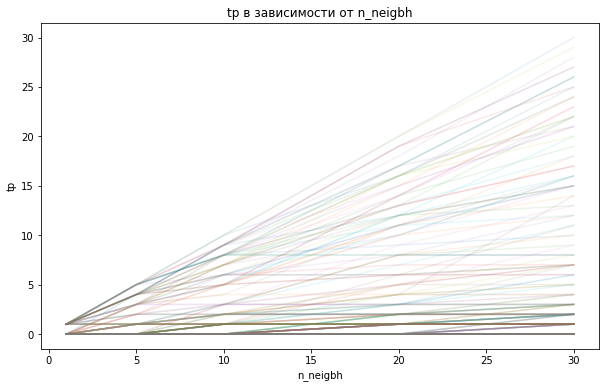

In [109]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["tp"], alpha=0.1)
plt.plot()
plt.title("tp в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("tp")
plt.show()

In [110]:
# средняя accuracy для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("n_neighb")["accuracy"].mean()

n_neighb
1     0.100000
5     0.090169
10    0.086271
20    0.078136
30    0.073616
Name: accuracy, dtype: float64

In [288]:
# средняя accuracy для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].groupby("n_neighb")["accuracy"].mean()

n_neighb
1     0.017778
5     0.009778
10    0.008889
20    0.008889
30    0.007556
Name: accuracy, dtype: float64

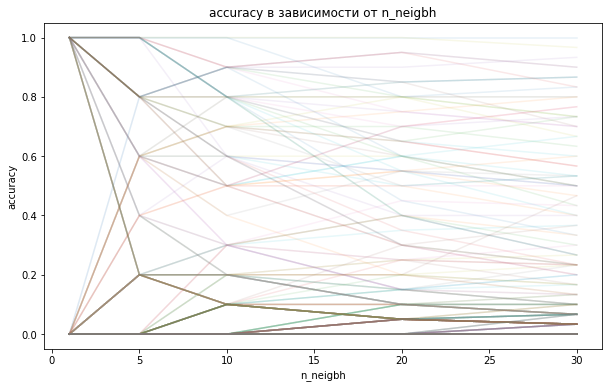

In [111]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["accuracy"], alpha=0.1)
plt.plot()
plt.title("accuracy в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("accuracy")
plt.show()

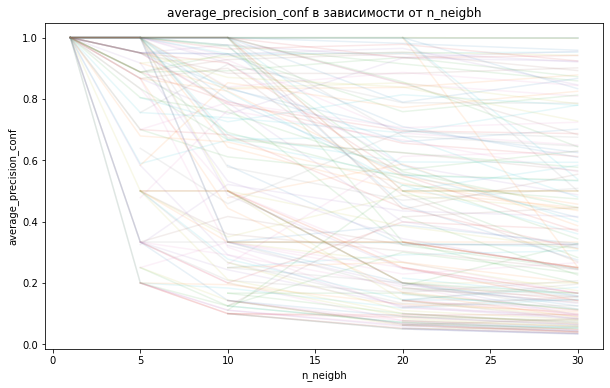

In [112]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["average_precision_conf"], alpha=0.1)
plt.plot()
plt.title("average_precision_conf в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("average_precision_conf")
plt.show()

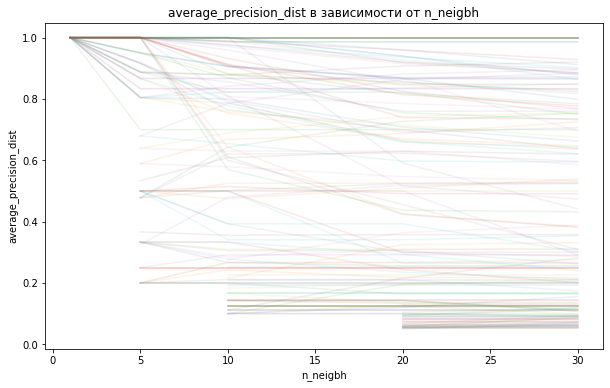

In [113]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["average_precision_dist"], alpha=0.1)
plt.plot()
plt.title("average_precision_dist в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("average_precision_dist")
plt.show()

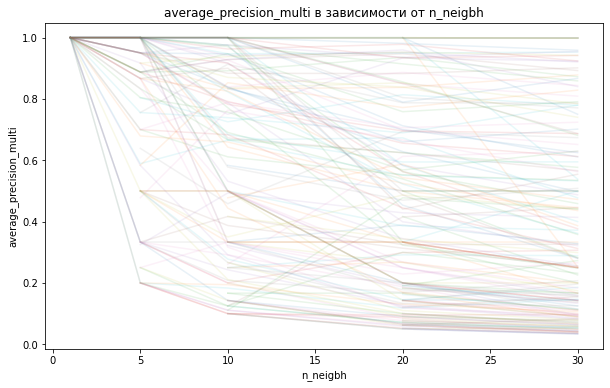

In [114]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["average_precision_multi"], alpha=0.1)
plt.plot()
plt.title("average_precision_multi в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("average_precision_multi")
plt.show()

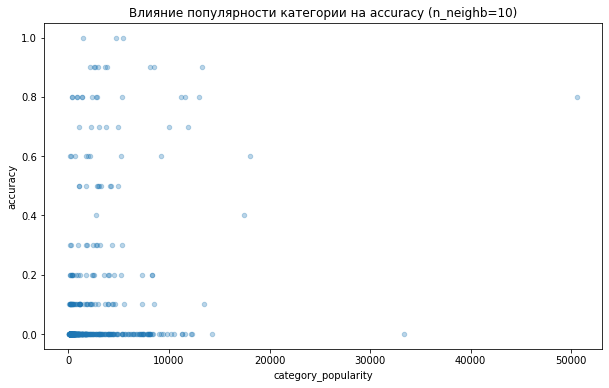

In [289]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)]
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .plot(
        "category_popularity",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на accuracy (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

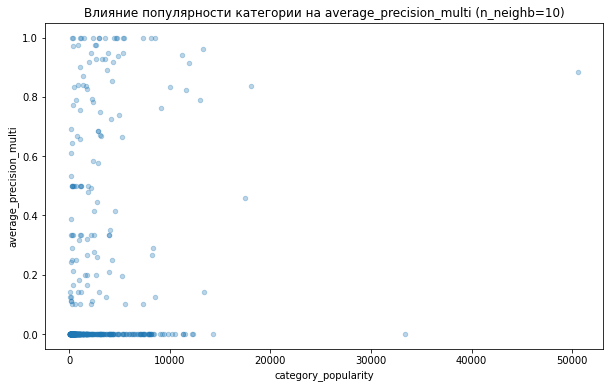

In [291]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)]
    .fillna(0)
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .plot(
        "category_popularity",
        "average_precision_multi",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на average_precision_multi (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

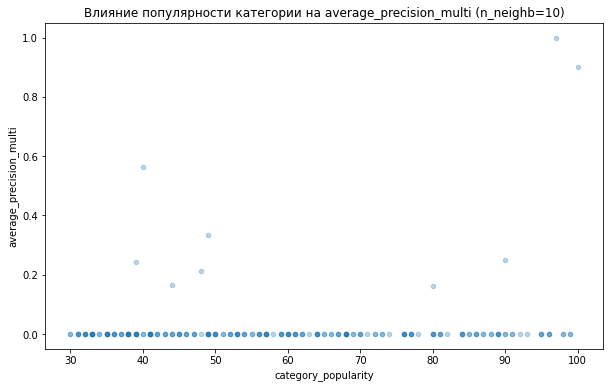

In [294]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)]
    .fillna(0)
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .plot(
        "category_popularity",
        "average_precision_multi",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на average_precision_multi (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

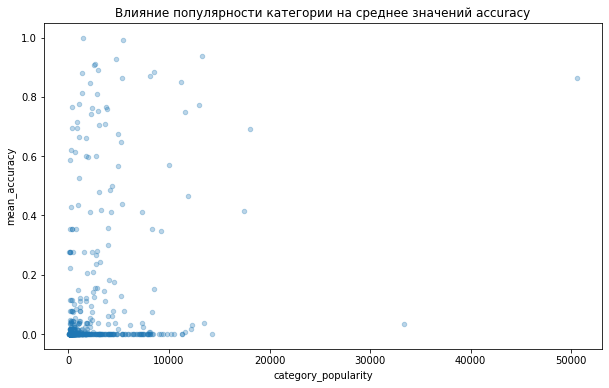

In [295]:
(
    metrics[metrics["category_id"].isin(ann[ann > 100].index)]
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .groupby(["category_id", "category_popularity"])["accuracy"]
    .mean()
    .reset_index(name="mean_accuracy")
    .plot(
        "category_popularity",
        "mean_accuracy",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на среднее значений accuracy",
        figsize=(10, 6),
    )
)
plt.show()

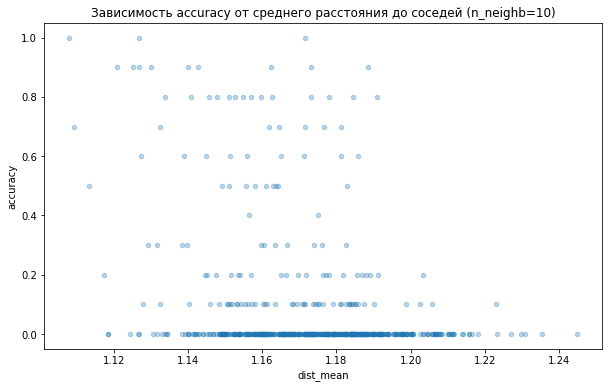

In [296]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].plot(
        "dist_mean",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Зависимость accuracy от среднего расстояния до соседей (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

In [118]:
# top категорий по минимальному расстоянию до соседей (что хорошо знает clip)
metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].sort_values("dist_mean").head(
    10
)

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,average_precision_multi,tp,dist_mean,conf_mean,iou_mean,accuracy
2222,445,fireplug,10,1.000000,1.000000,1.000000,10,1.107948,0.451091,0.961355,1.0
3827,766,parking_meter,10,0.756803,0.869048,0.756803,7,1.109305,0.552749,0.836200,0.7
5392,1079,tennis_racket,10,0.750000,0.794444,0.750000,5,1.113284,0.198756,0.811417,0.5
4832,967,ski_pole,10,0.266667,0.226190,0.266667,2,1.117245,0.153961,0.568721,0.2
3132,627,lamppost,10,NaN,NaN,NaN,0,1.118255,0.251827,NaN,0.0
3017,604,kettle,10,NaN,NaN,NaN,0,1.118332,0.183797,NaN,0.0
4877,976,snowboard,10,0.946781,0.878263,0.946781,9,1.120849,0.380982,0.912552,0.9
4822,965,ski_boot,10,NaN,NaN,NaN,0,1.124168,0.395707,NaN,0.0
4807,962,skateboard,10,0.946781,0.785670,0.928263,9,1.124978,0.602451,0.949389,0.9
4217,844,pretzel,10,NaN,NaN,NaN,0,1.126390,0.494957,NaN,0.0


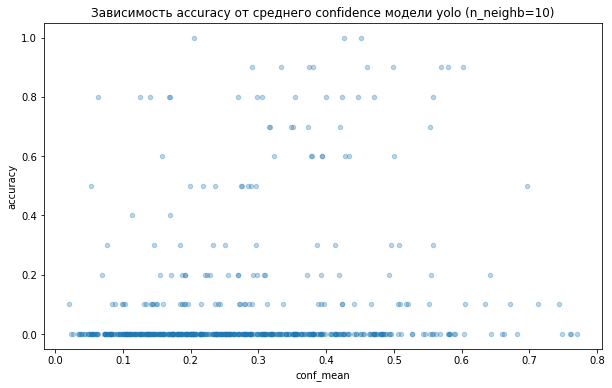

In [297]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].plot(
        "conf_mean",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Зависимость accuracy от среднего confidence модели yolo (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

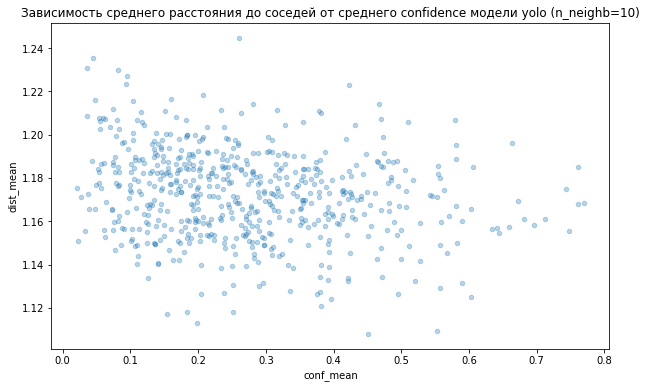

In [298]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].plot(
        "conf_mean",
        "dist_mean",
        kind="scatter",
        alpha=0.3,
        title="Зависимость среднего расстояния до соседей от среднего confidence модели yolo (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

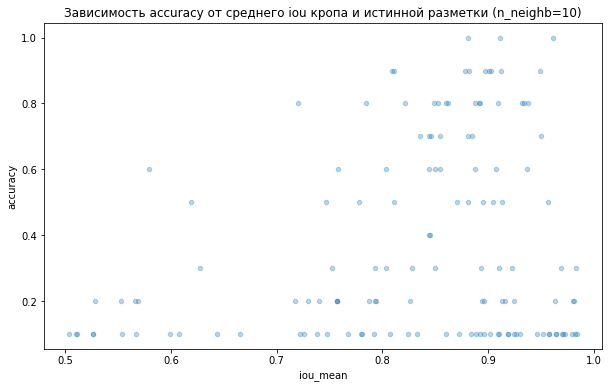

In [121]:
(
    metrics[
        (metrics["tp"] != 0) & (metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)
    ].plot(
        "iou_mean",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Зависимость accuracy от среднего iou кропа и истинной разметки (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()